In [1]:
import os
import astropy.io.fits as fits
import numpy as np
import scipy
import scipy.ndimage as ndi
import matplotlib.pylab as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pyklip.klip
import pyklip.instruments.Instrument as Instrument
import pyklip.parallelized as parallelized
import pyklip.rdi as rdi
import pyklip.fakes as fakes
import glob
from astropy.table import Table
from astropy.table import join
from astropy.table import vstack
import pandas as pd
import pdb

# Creating Contrast Curves

This notebook allows for the creation of contrast curves, first by simply making a raw contrast measurement, then by estimating and calibrating coronagraphic and algorithmic throughput and remeasuring the contrast. 

### Loading the dataset

In this tutorial, we will utilize the telescope's two roll angles and assume a process of angular differential imaging (ADI). When reading in our data, we need to specify the roll angles (10 arcseconds is the max), as well as the center of the image and the inner working angle in order to create a full sequence of images.

In [2]:
#Import the dataset to be used
filtername = "f300m"

# read in roll 1
with fits.open("old_simulated_data/NIRCam_target_Roll1_{0}.fits".format(filtername)) as hdulist:
    roll1_cube = hdulist[0].data

# read in roll 2
with fits.open("old_simulated_data/NIRCam_target_Roll2_{0}.fits".format(filtername)) as hdulist:
    roll2_cube = hdulist[0].data  

# combine the two rows
full_seq = np.concatenate([roll1_cube, roll2_cube], axis=0)

# two rolls are offset 10 degrees
pas = np.append([0 for _ in range(roll1_cube.shape[0])], [10 for _ in range(roll2_cube.shape[0])])

# for each image, the (x,y) center where the star is is just the center of the image
centers = np.array([np.array(frame.shape)/2. for frame in full_seq])

# give it some names, just in case we want to refer to them
filenames = np.append(["roll1_{0}".format(i) for i in range(roll1_cube.shape[0])],
                      ["roll2_{0}".format(i) for i in range(roll1_cube.shape[0])])

#Define dataset
dataset = Instrument.GenericData(full_seq, centers, IWA=4, parangs=pas, filenames=filenames)
dataset.flipx = False

### Run Klip

Next, we need to remove the starlight from our images in order to accurately measure contrast. We will break the image into 9 concentric annuli, and each annuli into 4 azimuthal sectors, then run KLIP on each of these sectors.

In [3]:
parallelized.klip_dataset(dataset, outputdir="./", fileprefix="pyklip-f300m-ADI-k50a9s4m1", annuli=9, 
                          subsections=4, numbasis=[1,5,10,20,50], mode="ADI", movement=1)

Begin align and scale images for each wavelength
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 36
27.78% done (9/36 completed)
55.56% done (19/36 completed)
83.33% done (29/36 completed)
Closing threadpool
Derotating Images...
Writing Images to directory /Volumes/Samsung_T5/JWST-ERS-Pipeline/notebooks
wavelength collapsing reduced data of shape (b, N, wv, y, x):(5, 12, 1, 101, 101)


/Users/jeaadams/pyklip/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)


### Mask Any Real Planets in Image

There are two "real" planets already in this dataset, but we don't want to include them in our noise estimation. Their positions are at pixel positions(41,54) and (43,70) respectively. We will therefore mask these positions with nans before calculating the contrast in our images. We used 5 KL modes to KLIP our data, but to create the contrast curve we only need 1 frame. We'll arbitrarily chose the KL mode with an index of 2 to accomplish this. 

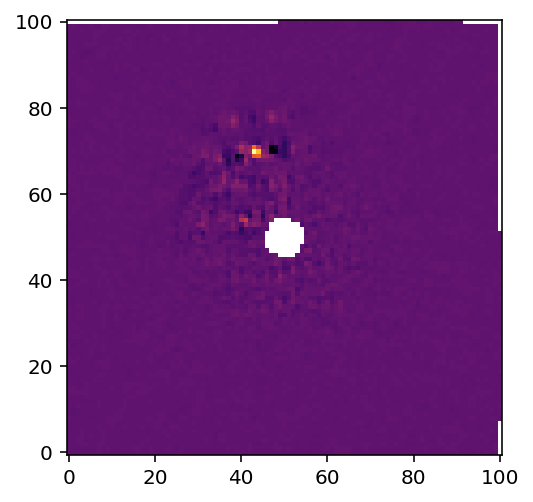

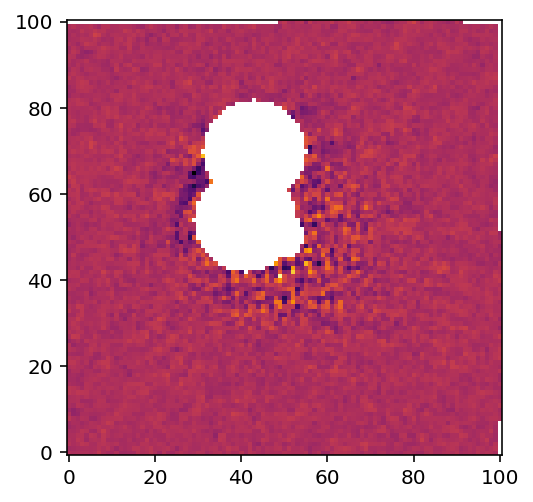

In [4]:
#Read in the KLIP-ed dataset
with fits.open("pyklip-f300m-ADI-k50a9s4m1-KLmodes-all.fits") as hdulist:
    adi_cube = hdulist[0].data
    adi_centers = [hdulist[0].header['PSFCENTX'], hdulist[0].header['PSFCENTY']]

    
#Plot the KL10 Cube (index of 2)
plt.figure() 
plt.imshow(adi_cube[2], interpolation='nearest', cmap='inferno')
plt.gca().invert_yaxis()
plt.savefig('subtract.png')

#Mask the 1st planet
planet1_peak_x = 41 
planet1_peak_y = 54

#Create an array with the indices are that of KL mode frame with index 2
ydat, xdat = np.indices(adi_cube[2].shape)

#Set the FWHM of the PSF
psf_fwhm = 6

#Calculate the distance around the planet to be masked
distance_from_planet1 = np.sqrt((xdat - planet1_peak_x)**2 + (ydat - planet1_peak_y)**2)

#Mask
adi_cube[2][np.where(distance_from_planet1 <= 2*psf_fwhm)] = np.nan

#Mask the second planet
planet2_peak_x = 43
planet2_peak_y = 70
distance_from_planet2 = np.sqrt((xdat - planet2_peak_x)**2 + (ydat - planet2_peak_y)**2)
adi_cube[2][np.where(distance_from_planet2 <= 2*psf_fwhm)] = np.nan

#plot the new masked data
plt.figure()
plt.imshow(adi_cube[2], interpolation='nearest', cmap='inferno')
plt.gca().invert_yaxis()

### Measure the Contrast

Using the pyKLIP function meas_contrast, we can now compute the 5 $\sigma$ noise at each separation in our image. For this function, we again need to specify our planet's FWHM as well as our outer working angle and the center of our input frame. 

In [ ]:
OWA = 65 #Setting this to be distance between star and outer edge of image

#Measuring the contrast in the image
contrast_seps, contrast = pyklip.klip.meas_contrast(dat = adi_cube[2], 
                                                     iwa = dataset.IWA, 
                                                     owa = OWA, 
                                                     resolution = (psf_fwhm), 
                                                     center = adi_centers,
                                                     low_pass_filter = False)
#Correct the contrast (Divide by peak)
contrast = contrast/bestfit[0]

In [ ]:
#Plot contrast curve!
plt.figure(figsize = (15,10))
plt.plot(contrast_seps, contrast, color = "teal")
plt.xlabel("Separation (pixels)")
plt.ylabel("Contrast (5 $\sigma$)")
plt.yscale('log')
plt.ylim(1e-6,1e-4)
plt.title("Raw Contrast Curve")
plt.rcParams.update({'font.size': 22})
plt.savefig("raw_contrast_test70pct.png", dpic = 500)

## Computing throughput

Now that we've created our contrast curve, we can calculate the throughput of our KLIP reduced images. In order to optimize this calculation, we need to inject multiple fake planets at varying separations and postion angles to get a feel for how throughput changes across the image.

### The Fake Planets to be Injected:

The injected fake planets will be scaled down versions of the unocculted PSF. The following code simply crops and centers this unocculted psf to prepare it for injection

In [ ]:
plt.imshow(roll2_cube[1],interpolation='nearest', cmap='inferno')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.gca().invert_yaxis()
plt.rcParams.update({'font.size': 14})
plt.savefig('psf.png', dpic = 500)


#### Generating a dataset
First, we need to generate data of the science target taken at two telescope roll angles. 

In [ ]:
#Import the dataset to be used
filtername = "f300m"

# read in roll 1
with fits.open("old_simulated_data/NIRCam_target_Roll1_{0}.fits".format(filtername)) as hdulist:
    roll1_cube = hdulist[0].data

# read in roll 2
with fits.open("old_simulated_data/NIRCam_target_Roll2_{0}.fits".format(filtername)) as hdulist:
    roll2_cube = hdulist[0].data  

# combine the two rows
full_seq = np.concatenate([roll1_cube, roll2_cube], axis=0)

# two rolls are offset 10 degrees
pas = np.append([0 for _ in range(roll1_cube.shape[0])], [10 for _ in range(roll2_cube.shape[0])])

# for each image, the (x,y) center where the star is is just the center of the image
centers = np.array([np.array(frame.shape)//2. for frame in full_seq])

# give it some names, just in case we want to refer to them
filenames = np.append(["roll1_{0}".format(i) for i in range(roll1_cube.shape[0])],
                      ["roll2_{0}".format(i) for i in range(roll1_cube.shape[0])])

#Define dataset
dataset = Instrument.GenericData(full_seq, centers, IWA=4, parangs=pas, filenames=filenames)
dataset.flipx = False

### Injecting the fake planets

Now that we have our data and have prepared our fake planet to be injected, we can choose how many we'd like to put into our dataset, what we want their relative fluxes to be, and their separations from the planet. For now, we'll inject three planets into a single dataset.

In [ ]:
mask210 = pd.read_csv("MASK210R.csv")
def transmission_corrected(input_stamp, input_dx, input_dy):
    distance_from_center = np.sqrt((input_dx)**2+(input_dy)**2)
    trans_at_dist = np.interp(distance_from_center, np.array(mask210["rad_dist"]),
                                     np.array(mask210["trans"]))
    transmission_stamp = trans_at_dist.reshape(input_stamp.shape)
    output_stamp = transmission_stamp*input_stamp
    return output_stamp

In [ ]:
#Let's choose our contrasts so that the planets get fainter as we go further from the star.
#We'll use our 5 sigma contrast curve to decided on the contrast values to use
psf_stamp_input = np.array([psf_stamp for j in range(12)])
input_contrasts = [7e-5, 6e-5, 5e-5, 4e-5, 3e-5,2e-5]

#only inject 30 or below so it doens't break. 
planet_seps = [20, 24, 28, 32, 36, 40]
#Change everything by 90 deg
pas = [0, 60, 120, 180, 240, 300]


#Now injecting the fake planets in a spiral:
for input_contrast, planet_sep, pa in zip(input_contrasts, planet_seps, pas):
    planet_fluxes = psf_stamp_input*input_contrast
    
    fakes.inject_planet(frames = dataset.input, 
                            centers=dataset.centers, 
                            inputflux=planet_fluxes, 
                            astr_hdrs=dataset.wcs, 
                            radius=planet_sep,
                            pa = pa,
                            field_dependent_correction = transmission_corrected)

### Run KLIP - Recover Planets

Now that we've injected our fake planets, we can check how well we were able to recover them by running KLIP. We'll only use 1 subsection and 1 annulus. 

In [ ]:
 #Set output directory
outputdir = 'contrastcurves'
fileprefix = 'FAKE_KLIP_ADI_A9K5S1M1'
numbasis = [1,5,10,20,50]
annuli = 1
subsections = 1
movement = 1


#Run KLIP on dataset with injected fakes
parallelized.klip_dataset(dataset, 
                          outputdir=outputdir, 
                          fileprefix=fileprefix, 
                          algo = 'klip', 
                          annuli=annuli, 
                          subsections=subsections, 
                          movement=movement, 
                          numbasis=numbasis, 
                          mode="ADI")

# Plot this reduced data cube. 
with fits.open("contrastcurves/FAKE_KLIP_ADI_A9K5S1M1-KLmodes-all.fits") as hdulist:
    adi_cube = hdulist[0].data
    
plt.figure()
# plot the KL10 Cube (index of 2)
plt.imshow(adi_cube[2], interpolation='nearest', cmap='inferno')
plt.gca().invert_yaxis()

### Recovering Flux Values

We can now visually inspect how well we were able to recover each injected planet, but if we want to quantify this algrorithm throughput, pyKLIP has a built in function "retrieve_planet_flux" so we can compare the retrieved flux to the input flux

In [ ]:
#Obtain the centers of the output KLIP fits file
with fits.open("contrastcurves/FAKE_KLIP_ADI_A9K5S1M1-KLmodes-all.fits") as hdulist:
    cube = hdulist[0].data[1]
    cube_centers = [hdulist[0].header['PSFCENTX'], hdulist[0].header['PSFCENTY']]

#Create and empty list to store retrieved flux values
retrieved_fluxes = []

#Retrieve planet fluxes
for input_contrast, planet_sep, pa in zip(input_contrasts, planet_seps, pas):
    
    fake_planet_fluxes = []
                                      
    fake_flux = fakes.retrieve_planet_flux(frames = cube, 
                                        centers = cube_centers,
                                        astr_hdrs = dataset.output_wcs[0], 
                                        sep = planet_sep,
                                        pa = pa)
    fake_planet_fluxes.append(fake_flux)

    retrieved_fluxes.append(fake_flux)

### Calculating throughput

Now that we've run a full reduction on the data with injected planets, we can calculate the throughput to figure our how well we were able to recover the planet at different separations. 

Throughput can be calculated as follows: throughput = $\frac{output\ flux}{input\ flux}$. We'll need to calculate the input flux first by multiplying our input contrasts by the peak star flux estimated from our previous Gaussian fit.

In [ ]:
#Calculate the input flux
input_flux = [contrast*bestfit[0] for contrast in input_contrasts]

#Put everything in table form (as a dataframe)
throughput_table = pd.DataFrame(
    {'retrieved_fluxes': retrieved_fluxes,
     'input_flux': input_flux,
     'separation': planet_seps
     })

#Calculate througput and put it in a column in the dataframe

throughput_table["throughput"] = throughput_table["retrieved_fluxes"]/throughput_table["input_flux"]

In [ ]:
throughput_table

### Now we can visualize our throughput as a function of separation

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(throughput_table["separation"], throughput_table["throughput"])
plt.xlabel("Separation (pixels)")
plt.ylabel("Throughput")
plt.title("Throughput as a Function of Separation from Star")

## Improving throughput

From this plot, we can see that our throughput improves as a function of separation from the host star. Still, our plot is could benefit from a few more data points. If we could inject fake planets in every available space in our data, we'd get a much better sense of how throughput varies as a function of separation. However, this turns out to be quite tedious and messy. Instead, we'll inject only a few fake planets in an image, but do this for different separations in multiple images and record the throughput for each image. This will give us the same information in a much cleaner way.   

To do this, we'll create a loop that injects **n** planets at a set list of separations, but changing the position angle each time. Every time it injects a new set of fake planets, it runs pyKLIP on the injected dataset, and then retrieves the fluxes of the fake planets from the KLIP-ed data to be output into a table.  
Since we're using a loop to inject fake planets in new locations each time, we also need to regenerate a new dataset each time. The following 'generate datasets' function will create as many datasets as the user would like, which would be equal to the desried number of reductions.

In [ ]:
def generate_datasets(num_datasets):
    """
    Generates multiple generic datasets based on the two JWST roll angles 0" and 10"
    
    Args:
        num_datasets(int): Number of datasets to be generated
    
    Returns:
        datasets(list): List of generated datasets
    """
    datasets = []
    for dataset in range(num_datasets):

        #Import the dataset to be used
        filtername = "f300m"

        # read in roll 1
        with fits.open("old_simulated_data/NIRCam_target_Roll1_{0}.fits".format(filtername), memmap = False) as hdulist:
            roll1_cube = hdulist[0].data

        # read in roll 2
        with fits.open("old_simulated_data/NIRCam_target_Roll2_{0}.fits".format(filtername), memmap = False) as hdulist:
            roll2_cube = hdulist[0].data  

        # combine the two rows
        full_seq = np.concatenate([roll1_cube, roll2_cube], axis=0)

        # two rolls are offset 10 degrees
        pas = np.append([0 for _ in range(roll1_cube.shape[0])], [10 for _ in range(roll2_cube.shape[0])])

        # for each image, the (x,y) center where the star is is just the center of the image
        centers = np.array([np.array(frame.shape)//2. for frame in full_seq])

        # give it some names, just in case we want to refer to them
        filenames = np.append(["roll1_{0}".format(i) for i in range(roll1_cube.shape[0])],
                              ["roll2_{0}".format(i) for i in range(roll1_cube.shape[0])])

        #Define dataset
        dataset = Instrument.GenericData(full_seq, centers, IWA=4, parangs=pas, filenames=filenames)
        dataset.flipx = False
        datasets.append(dataset)
        
        return datasets

### To begin the loop:

1) Specify how many reductions you'd like to run  
2) Specify input contrasts and planet separations. There should be an equal number of elements in both lists.  
3) Specify starting position angle and amount by which to change position angle each loop  

### What it does
* Injects fake planets with  fakes.inject_planet  
* Run KLIP on fake injected dataset  
* Read in the KLIP-ed dataset    
* Retrieved fluxes of injected planets with fakes.retrieve_planet_flux  
* Append retrieved fluxes, planet separtions and contrasts to a list  
* Calculates the throughput value
* Outputs all data into two throughput tables, one containing all the data, and one containing median throughput values by separation.

In [ ]:
def multiple_planet_injection(input_contrasts, planet_seps, pas, pas_step_size, num_datasets):
    """
    Injects multiple fake planets across multiple datasets, changing the position angle of injection each time. 
    
    Args:
        planet_seps (float): List of separations planets should be injected at (match order with desired contrast in list)
        pas (float): List of position angles to inject fake planets at during first iteration
        pas_step_size(float): Amount by which position angles should be increased during each iteration
        num_datastes(int): The number of datasets to be generated. This is equal to the number of interations of planet injection/number of position angle changes
        input_contrasts(float): List of contrasts planets should be injected at
    Returns:
        retrieved_values(pandas table): Table of values retrieved for retrieved_flux and throughput at each pa and separation. 
    """
    
    pas_all = [] 
    retrieved_fluxes_all = []
    planet_seps_all = [] 
    input_contrasts_all = []
    

    
    #generate desired number of datasets
    datasets = generate_datasets(num_datasets)
    
    #begin fake planets injection and retrieval, changing pa each time
    for dataset_num, dataset in enumerate(datasets):
        
        #Create stamps of the point spread function to be injected as a fake planet
        psf_stamp_input = np.array([psf_stamp for j in range(12)])
        
        #Create an array of the position angles planets should be injected at, accounting for the roll angles
        pas_array = [x+pas_step_size*dataset_num for x in pas]
        
        
        start_over = False
        
        
        #Inject fake planets
        for input_contrast, planet_sep, pa in zip(input_contrasts, planet_seps, pas_array):
            
            # Check the distance between the planet to be injected and the planets already in the data. We don't want to inject fake planets too close to the two planets already in the data.
            check_sep_x = planet_sep*np.cos((pa + 90)) 
            check_sep_y = planet_sep*np.sin((pa + 90))
            dist_p1 = np.sqrt((check_sep_x - planet1_peak_x)**2 + (check_sep_y - planet1_peak_y)**2)
            dist_p2 = np.sqrt((check_sep_x - planet2_peak_x)**2 + (check_sep_y - planet2_peak_y)**2)
            
            #Make sure fake planets won't be injected within a 12 pixel radius of the real planets
            if dist_p1 > 12 and dist_p2 > 12:
                planet_fluxes = psf_stamp_input*input_contrast


                fakes.inject_planet(frames = dataset.input, 
                                    centers=dataset.centers, 
                                    inputflux=planet_fluxes, 
                                    astr_hdrs=dataset.wcs, 
                                    radius=planet_sep,
                                    pa = pa,
                                    field_dependent_correction = transmission_corrected)
            
            #If the fake planet to be injected is within a 12 pixel radius of the real planets, start over the loop
            else:
                start_over = True
                
        if start_over:
            continue
            
        ######################################################################################################
        
        #Run KLIP on datasets with injected planets
        
        
        #Set output directory
        outputdir = "contrastcurves"
        fileprefix = "FAKE_KLIP_ADI_A9K5S4M1" + str(dataset_num)
        filename = "FAKE_KLIP_ADI_A9K5S4M1" + str(dataset_num) + "-KLmodes-all.fits"
        numbasis = [1,5,10,20,50]


        #Run KLIP on dataset with injected fakes
        parallelized.klip_dataset(dataset, 
                                  outputdir=outputdir, 
                                  fileprefix=fileprefix, 
                                  algo = 'klip', 
                                  annuli=1, 
                                  subsections=1, 
                                  movement=1, 
                                  numbasis=numbasis, 
                                  mode="ADI")
        
        ######################################################################################################
        
        #Retireve fake planet fluxes from the KLIP-ed dataset
        
        
        #Open one frame of the KLIP-ed dataset
        klipdataset = os.path.join(outputdir,filename)
        with fits.open(klipdataset, memmap = False) as hdulist:
            outputfile = hdulist[0].data
            outputfile_centers = [hdulist[0].header['PSFCENTX'], hdulist[0].header['PSFCENTY']]
        outputfile_frame = outputfile[2]

        
        
        retrieved_planet_fluxes = []
        
        #Retrieve planet flux function
        for input_contrast, planet_sep, pa in zip(input_contrasts, planet_seps, pas_array):

            fake_flux = fakes.retrieve_planet_flux(frames = outputfile_frame, 
                                                    centers=outputfile_centers,
                                                    astr_hdrs=dataset.output_wcs[0], 
                                                    sep=planet_sep,
                                                    pa = pa,
                                                    searchrad = 7)

            retrieved_planet_fluxes.append(fake_flux)
            
        
        retrieved_fluxes_all.append(retrieved_planet_fluxes)
        pas_all.append(pas)
        planet_seps_all.append(planet_seps)
        input_contrasts_all.append(input_contrasts)
        
        ######################################################################################################
        
    #Creating output table
    retrieved_fluxes_all = np.array(retrieved_fluxes_all).ravel()
    pas_all = np.array(pas_all).ravel()
    planet_seps_all = np.array(planet_seps_all).ravel()
    input_contrasts_all = np.array(input_contrasts_all).ravel()


    #Loop through each list to create a table of all variables
    
    flux_sep = Table([retrieved_fluxes_all,planet_seps_all, input_contrasts_all, pas_all], names = ('flux', 'separation', 'input_contrast', 'pas'))
    flux_sep['input_flux'] = flux_sep['input_contrast']*bestfit[0]
    #Calculate throughput and add it to list 
    flux_sep['throughput'] = flux_sep['flux']/flux_sep['input_flux']

    #We can also calculate the median througput per separation

    #Group by separation
    flux_by_sep = flux_sep.group_by('separation')

    #Calculate the median value for each separation group
    med_flux_by_sep = flux_by_sep.groups.aggregate(np.median)

       
    
    return flux_sep, med_flux_by_sep

In [ ]:
output_table, output_table_bysep = multiple_planet_injection(input_contrasts = [8e-5, 7e-5, 6e-5, 5e-5, 4e-5, 3e-5,2e-5, 1e-5],
          planet_seps = [12, 15, 20, 24, 28, 32, 36, 40],
          pas = [0, 30, 60, 120, 180, 240, 300, 360], 
          pas_step_size = 60,
          num_datasets = 10)

In [ ]:
throughput_all_table = pd.read_csv('throughput_all.csv')
throughput_bysep_table = pd.read_csv('throughput_bysep.csv')

In [ ]:
plt.figure(figsize = (15,10))
plt.plot(throughput_bysep_table["separation"], throughput_bysep_table["throughput"], color = 'black', label = 'Median Throughput')
plt.scatter(throughput_all_table["separation"], throughput_all_table["throughput"], edgecolors = 'black', s = 80,color = '#BF9ACA', label = "Calculated Throughput Value", alpha = 0.5)
plt.ylabel("Throughput")
plt.xlabel("Planet Separation")
plt.title("Algorithm Throughput")
plt.legend(frameon = False, loc = 'lower left')
plt.rcParams.update({'font.size': 22})
plt.savefig("throughput_med_8.png")

In [ ]:
contrast_table = throughput_bysep_table.join(contrast_stuff.set_index('separation'), on = 'separation')

In [ ]:
#Normalize the noise contrast by the measured throughput level at that separation
contrast_table['corrected_contrast']=contrast_table['contrast']/contrast_table['throughput']

In [ ]:
contrast_table = contrast_table.dropna()

In [ ]:
contrast_table

In [ ]:
plt.figure(figsize = (15,10))
plt.plot(contrast_table['separation'], contrast_table['corrected_contrast'], color = 'teal')
plt.rcParams.update({'font.size': 20})
plt.ylabel('Corrected Contrast')
plt.xlabel('Separation (pixels)')
plt.yscale('log')